<a href="https://colab.research.google.com/github/FatihUlumuddin/Morfologi-Deteksi-Kanker-Paru-Menggunakan-Segmentasi-Citra-CT/blob/main/Deteksi%20Kanker%20Paru%20Menggunakan%20Segmentasi%20Citra%20CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tcia-utils


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 14.6 MB/s eta 0:00:00


In [7]:
!pip install pydicom


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.6 MB/s eta 0:00:00


In [8]:
import requests
import os
import zipfile
import pydicom
import matplotlib.pyplot as plt


In [9]:
collections_url = "https://services.cancerimagingarchive.net/services/v4/TCIA/query/getCollectionValues"
collections = requests.get(collections_url).json()

print("Daftar Koleksi:")
for c in collections:
    print(c['Collection'])


Daftar Koleksi:
4D-Lung
ACRIN-FLT-Breast
ACRIN-NSCLC-FDG-PET
APOLLO
Anti-PD-1_Lung
BREAST-DIAGNOSIS
Breast-MRI-NACT-Pilot
C4KC-KiTS
CBIS-DDSM
CC-Radiomics-Phantom
CC-Radiomics-Phantom-2
CC-Radiomics-Phantom-3
CPTAC-CCRCC
CPTAC-CM
CPTAC-LSCC
CPTAC-LUAD
CPTAC-PDA
CPTAC-SAR
CPTAC-UCEC
CT COLONOGRAPHY
CT Lymph Nodes
DRO-Toolkit
ISPY1
LCTSC
LIDC-IDRI
Lung Phantom
Lung-Fused-CT-Pathology
Lung-PET-CT-Dx
LungCT-Diagnosis
MRI-DIR
Mouse-Astrocytoma
Mouse-Mammary
NSCLC Radiogenomics
NSCLC-Radiomics-Interobserver1
NSCLC-Radiomics
NSCLC-Radiomics-Genomics
NaF PROSTATE
PDMR-292921-168-R
PDMR-BL0293-F563
PROSTATE-DIAGNOSIS
PROSTATE-MRI
PROSTATEx
Pancreas-CT
Pelvic-Reference-Data
Phantom FDA
Prostate Fused-MRI-Pathology
Prostate-3T
Prostate-MRI-US-Biopsy
QIBA CT-1C
QIN Breast DCE-MRI
QIN LUNG CT
QIN PET Phantom
QIN-BREAST
QIN-PROSTATE-Repeatability
RIDER Breast MRI
RIDER Lung CT
RIDER Lung PET-CT
RIDER PHANTOM MRI
RIDER PHANTOM PET-CT
SPIE-AAPM Lung CT Challenge
Soft-tissue-Sarcoma
TCGA-BLCA
TCGA-BRCA

In [10]:
collection_name = "SPIE-AAPM Lung CT Challenge"
patients_url = f"https://services.cancerimagingarchive.net/services/v4/TCIA/query/getPatient?Collection={collection_name}"
patients = requests.get(patients_url).json()

patient_id = patients[0]['PatientID']
print("Patient ID:", patient_id)


Patient ID: CT-Training-BE006


In [14]:
import requests
import os
import zipfile
import pydicom
import matplotlib.pyplot as plt


In [15]:
collection_name = "SPIE-AAPM Lung CT Challenge"
series_url = f"https://services.cancerimagingarchive.net/services/v4/TCIA/query/getSeries?Collection={collection_name}"

series_list = requests.get(series_url).json()

if not series_list:
    raise Exception("❌ Tidak ada seri ditemukan dalam koleksi.")

series_uid = series_list[0]['SeriesInstanceUID']
print("✅ SeriesInstanceUID ditemukan:", series_uid)


✅ SeriesInstanceUID ditemukan: 1.2.840.113704.1.111.1724.1168392386.17


In [16]:
output_dir = "dicom_files"
os.makedirs(output_dir, exist_ok=True)

download_url = f"https://services.cancerimagingarchive.net/services/v4/TCIA/query/getImage?SeriesInstanceUID={series_uid}"
zip_path = os.path.join(output_dir, f"{series_uid}.zip")

with requests.get(download_url, stream=True) as r:
    with open(zip_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print("✅ File ZIP berhasil diunduh:", zip_path)


✅ File ZIP berhasil diunduh: dicom_files/1.2.840.113704.1.111.1724.1168392386.17.zip


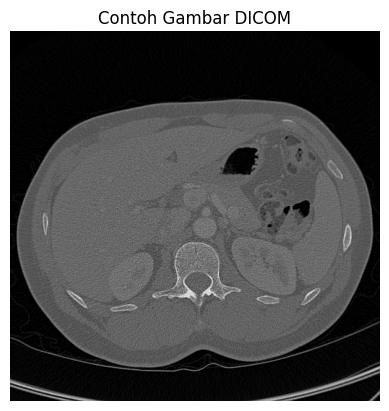

In [17]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

dicom_files = [f for f in os.listdir(output_dir) if f.endswith(".dcm")]
if not dicom_files:
    raise Exception("❌ Tidak ada file DICOM ditemukan setelah ekstraksi.")

dicom_path = os.path.join(output_dir, dicom_files[0])
ds = pydicom.dcmread(dicom_path)

plt.imshow(ds.pixel_array, cmap='gray')
plt.title("Contoh Gambar DICOM")
plt.axis('off')
plt.show()


In [18]:
!pip install opencv-python scikit-image


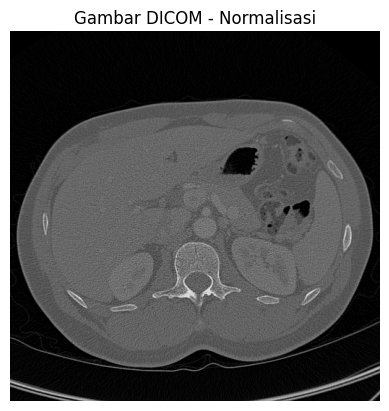

In [19]:
import cv2
import numpy as np
from skimage import exposure

image = ds.pixel_array.astype(np.float32)

image = exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8)

plt.imshow(image, cmap='gray')
plt.title("Gambar DICOM - Normalisasi")
plt.axis('off')
plt.show()


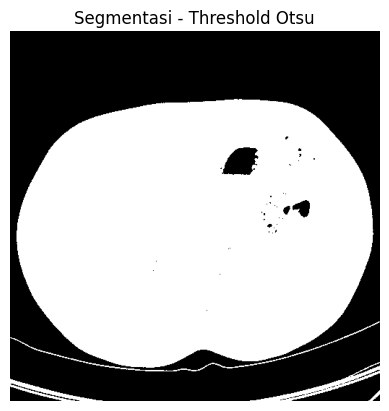

In [20]:
_, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(binary, cmap='gray')
plt.title("Segmentasi - Threshold Otsu")
plt.axis('off')
plt.show()


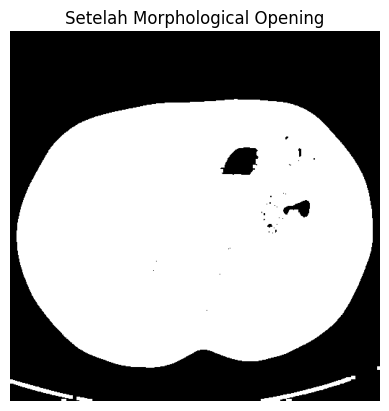

In [21]:
kernel = np.ones((5, 5), np.uint8)

opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

plt.imshow(opened, cmap='gray')
plt.title("Setelah Morphological Opening")
plt.axis('off')
plt.show()


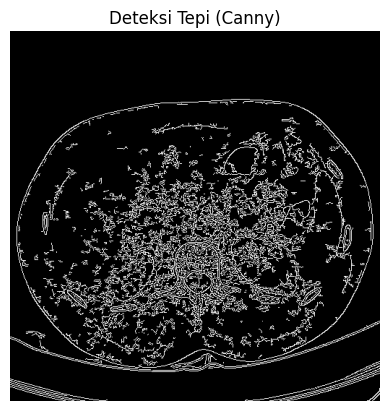

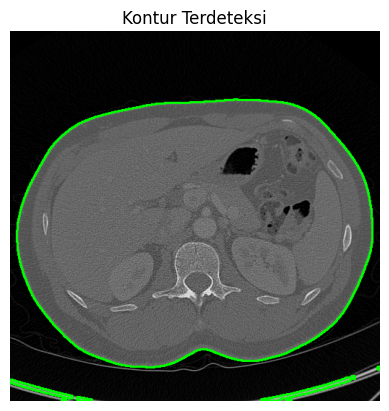

In [22]:
edges = cv2.Canny(image, 50, 150)

plt.imshow(edges, cmap='gray')
plt.title("Deteksi Tepi (Canny)")
plt.axis('off')
plt.show()

contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, contours, -1, (0,255,0), 2)

plt.imshow(contour_image)
plt.title("Kontur Terdeteksi")
plt.axis('off')
plt.show()
